Most of the time we only have few images for good/bad parts in the industry, 
so we will try to detect wood knots as segment with just a few images.

## Import dependencies

In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys
import pathlib
current_path = pathlib.Path().absolute()
root_path = "{0}/..".format(current_path)
sys.path.append("{0}/src".format(root_path))

import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam

import backbones
import utils.plots as plots
from train_engine import TrainEngine
from utils import load_dataset, ImageGeneratorConfig, setup_environment

In [2]:
setup_environment(enable_gpu=True)

## Prepare training and evaluation

As we have only few images, we need to augment them to get more input for our neuronal network.

In [3]:
train_files_path = "{0}/img/wood_plate/train".format(root_path)
eval_files_path = "{0}/img/wood_plate/eval".format(root_path)
checkpoints_save_path = "{0}/checkpoints".format(root_path)

input_shape = (512, 512, 1)
generator_config = ImageGeneratorConfig()
generator_config.loop_count = 10
generator_config.horizontal_flip = True
generator_config.zoom_range = 0.3
generator_config.width_shift_range = 0.3
generator_config.height_shift_range = 0.3
generator_config.rotation_range = 10

train_x, train_y, eval_x, eval_y = load_dataset(
    train_files_path, input_shape, validation_split=0
)

eval_x, eval_y, t1, t2, = load_dataset(
    eval_files_path, input_shape, validation_split=0
)

No classes detected, will continue without classes!
Using masks as train_y
No classes detected, will continue without classes!
Using masks as train_y


## Create model

In [4]:
backbone = backbones.SegmentationVanillaUnet(input_shape)
optimizer = Adam(lr=1e-5)

## Create train engine

In [5]:
train_engine = TrainEngine(
    input_shape, 
    backbone.model, 
    optimizer, 
    loss="binary_crossentropy",
    checkpoints_save_path=checkpoints_save_path,
    checkpoint_save_period=generator_config.loop_count * 10, # Should always multiplied with the generator loop_count (will save every 10th epoch)
)

## Train model

In [6]:
loss, acc, val_loss, val_acc = train_engine.train(
    train_x,
    train_y,
    eval_x,
    eval_y,
    epochs=50,
    batch_size=16,
    image_generator_config=generator_config,
)

Epoch 10/50	loss: 0.06453	acc: 0.99061	val_loss: 0.07411	val_acc: 0.98225
Epoch 20/50	loss: 0.05145	acc: 0.9918	val_loss: 0.07121	val_acc: 0.98227
Epoch 30/50	loss: 0.04496	acc: 0.992	val_loss: 0.06218	val_acc: 0.98277
Epoch 40/50	loss: 0.03832	acc: 0.99259	val_loss: 0.05096	val_acc: 0.98498
Epoch 50/50	loss: 0.03311	acc: 0.99328	val_loss: 0.04318	val_acc: 0.98705


## Show history

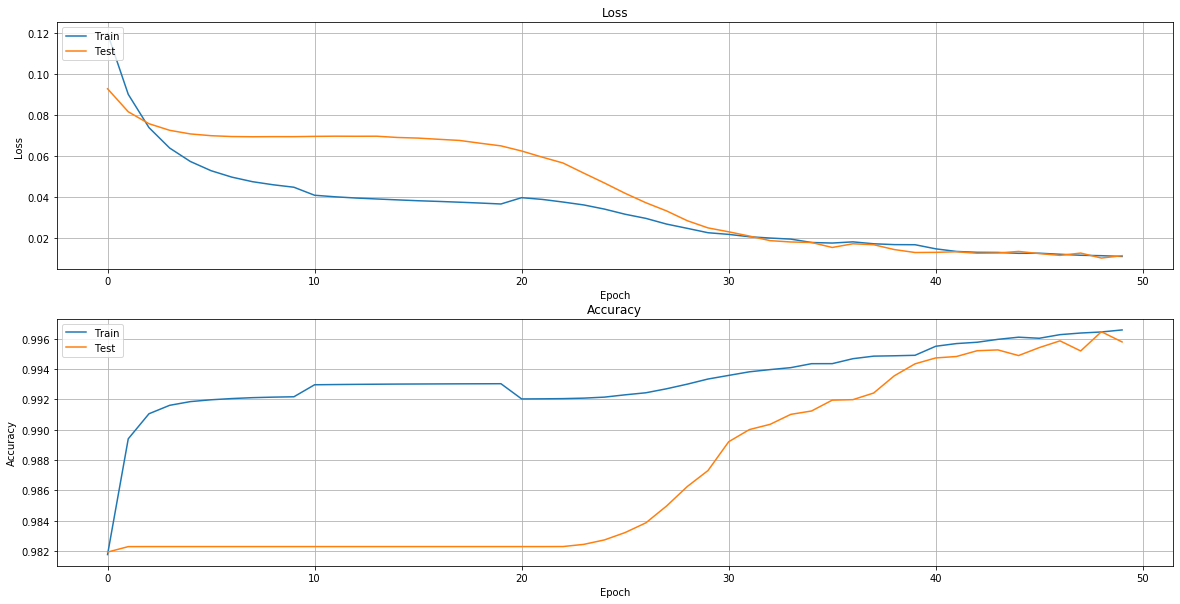

In [7]:
plots.plot_history(loss, acc, val_loss, val_acc)

## Predict

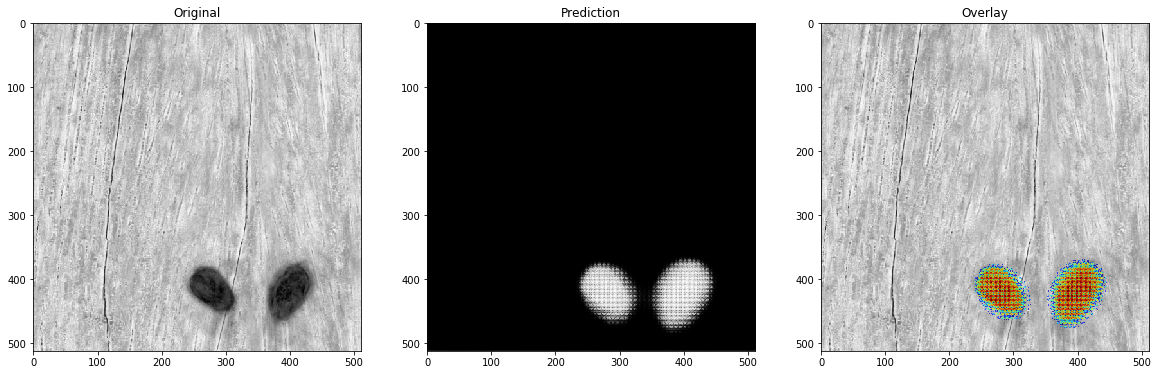

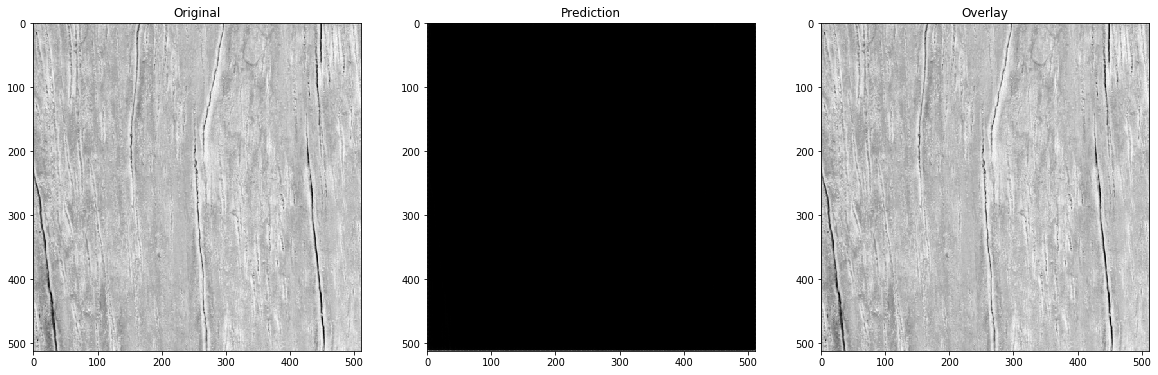

In [8]:
for idx in range(len(eval_x[:2])):
    predictions = train_engine.model.predict(
        np.array([eval_x[idx]], dtype=np.float32), batch_size=1
    )
    plots.plot_prediction(predictions, [eval_x[idx]], input_shape)

## Cleanup

In [9]:
K.clear_session()